# Criminal Networks: Sicilian Mafia 

based on [this notebook](https://github.com/maelfabien/NetworkDisruption/blob/master/Exploration.ipynb) by Maël Fabien, which in turn is based on ["Disrupting resilient criminal networks through data analysis: the case of Sicilian Mafia"](https://arxiv.org/pdf/2003.05303) by Lucia Cavallaro and Annamaria Ficara.

In [16]:
import data_utils
import seaborn as sns
from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

def get_giant_compoent(g: nx.Graph)->nx.Graph:
    """
    Returns the giant component of a graph
    """
    giant = max(nx.connected_components(g), key=len)
    return g.subgraph(giant)


## First exploration

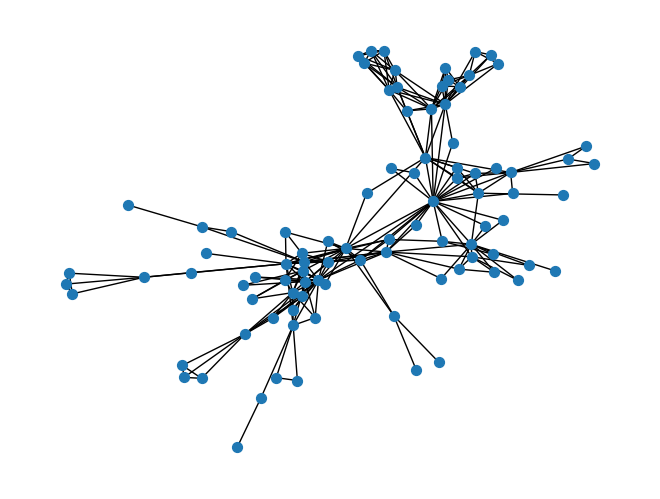

In [17]:
G = data_utils.load_graph_from_local("Montagna_meetings_edgelist.csv")
pos = nx.spring_layout(G)
nx.draw(get_giant_compoent(G), pos, with_labels=False, node_size=50, font_size=8)

In [3]:
c_degree = nx.degree_centrality(G)
c_degree = list(c_degree.values())
c = list(greedy_modularity_communities(G))

nb_nodes = len(list(G.nodes()))
nb_edges = len(list(G.edges()))
degrees = list(dict(G.degree()).values())
avg_degree = np.mean(degrees)
median_degree = np.median(degrees)
max_degree = np.max(degrees)        
min_degree = np.min(degrees) 
avg_centrality = np.mean(c_degree) 
min_centrality = np.min(c_degree) 
max_centrality = np.max(c_degree) 
median_centrality = np.median(c_degree) 

In [4]:
print("Number of nodes: ", nb_nodes)
print("Number of edges: ", nb_edges)
print("Average degree: ", avg_degree)
print("Median degree: ", median_degree)
print("Max degree: ", max_degree)
print("Min degree: ", min_degree)
print("Average centrality: ", avg_centrality)
print("Median centrality: ", median_centrality)
print("Max centrality: ", max_centrality)
print("Min centrality: ", min_centrality)

Number of nodes:  101
Number of edges:  256
Average degree:  5.069306930693069
Median degree:  3.0
Max degree:  24
Min degree:  1
Average centrality:  0.050693069306930696
Median centrality:  0.03
Max centrality:  0.24
Min centrality:  0.01


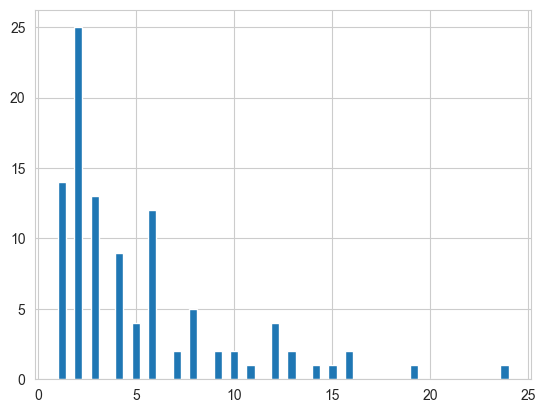

In [8]:
fig, ax = plt.subplots()
ax.hist(degrees, bins=55);

# Network matching

Graph with 101 nodes and 256 edges
Graph with 100 nodes and 124 edges
Graph with 154 nodes and 342 edges


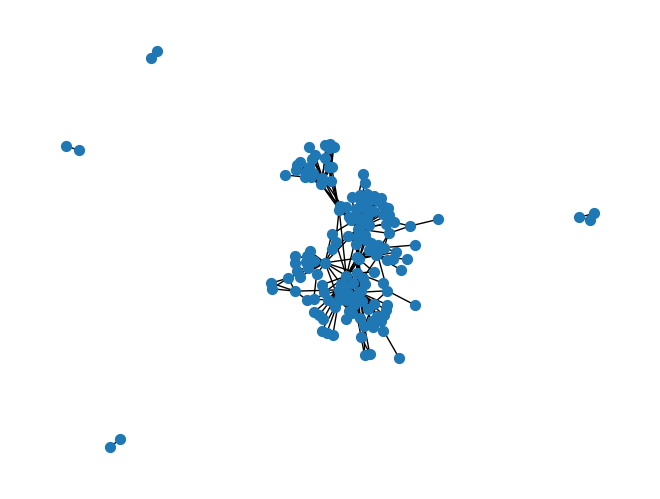

In [31]:
G_phones = data_utils.load_graph_from_local("Montagna_phonecalls_edgelist.csv")
G_combined = G.copy()
for u, v, data in G_phones.edges(data=True):
    if G_combined.has_edge(u, v):
        G_combined[u][v]['weight'] += data['weight']
    else:
        G_combined.add_edge(u, v, weight=data['weight'])
    
print(G)
print(G_phones)
print(G_combined) 
# G_combined = get_giant_compoent(G_combined)
nx.draw(G_combined, with_labels=False, node_size=50, font_size=8)

In [32]:
c_degree_dct = dict(nx.betweenness_centrality(G_combined))
c_degree = np.array(list(c_degree_dct.values()))
c = list(greedy_modularity_communities(G_combined))

nb_nodes = len(list(G_combined.nodes()))
nb_edges = len(list(G_combined.edges()))
degrees = list(dict(G_combined.degree()).values())
avg_degree = np.mean(degrees)
median_degree = np.median(degrees)
max_degree = np.max(degrees)        
min_degree = np.min(degrees) 
avg_centrality = np.mean(c_degree) 
min_centrality = np.min(c_degree) 
max_centrality = np.max(c_degree) 
median_centrality = np.median(c_degree) 

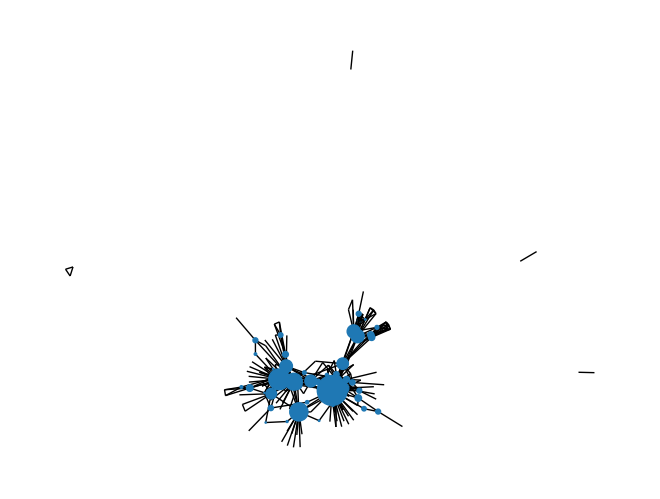

In [33]:
pos = nx.fruchterman_reingold_layout(G_combined)
nx.draw(G_combined, pos, with_labels=False, node_size=c_degree*1000, font_size=8)

In [34]:
print("Number of nodes: ", nb_nodes)
print("Number of edges: ", nb_edges)
print("Average degree: ", avg_degree)
print("Median degree: ", median_degree)
print("Max degree: ", max_degree)
print("Min degree: ", min_degree)
print("Average centrality: ", avg_centrality)
print("Median centrality: ", median_centrality)
print("Max centrality: ", max_centrality)
print("Min centrality: ", min_centrality)

Number of nodes:  154
Number of edges:  342
Average degree:  4.441558441558442
Median degree:  2.0
Max degree:  41
Min degree:  1
Average centrality:  0.0130344801397433
Median centrality:  0.0
Max centrality:  0.46137941336697935
Min centrality:  0.0


# Metrics and Disruption

In [35]:
def collective_influence(graph, node, weight=None):
    """
    Calculate the collective influence centrality for a specific node in a graph.
    
    [Based on Influence maximization in complex networks through optimal percolation](
    https://arxiv.org/pdf/1506.08326)
    
    Parameters:
    graph (networkx.Graph): The input graph.
    node (int): The node for which to calculate the collective influence.
    weight (str, optional): The edge attribute to be used as weight. Defaults to None.
    
    Returns:
    float: The collective influence centrality of the node.
    """
    sum_neighbors = 0
    for neighbor in graph.neighbors(node):
        if weight is None:
            sum_neighbors += graph.degree(neighbor) - 1
        else:
            sum_neighbors += graph.degree(neighbor, weight='weight') - 1
    if weight is None:
        return (graph.degree(node) - 1) * sum_neighbors
    else:
        return (graph.degree(node) - 1) * sum_neighbors

def determine_nodes_to_remove(
        graph,
        num_nodes_to_remove=5,  # Number of nodes to be removed.
        method='collective_influence',  # Method to determine centrality computation.
        weight=None):
    """
    Calculate the centrality of nodes in a graph using the specified method and determine the 
    top `num_nodes_to_remove` nodes to remove in order to disrupt the network.
    
    Parameters:
    graph (networkx.Graph): The input graph.
    num_nodes_to_remove (int): Number of nodes to be removed.
    method (str): The method to determine the centrality computation ('betweenness', 'degree', 'collective_influence', 'random').
    weight (str, optional): The edge attribute to be used as weight. Defaults to None.
    
    Returns:
    list: A list of the nodes to be removed based on their centrality score.
    """
    if method == 'betweenness':
        centrality_scores = nx.betweenness_centrality(graph, weight=weight)
    elif method == 'degree':
        centrality_scores = nx.degree_centrality(graph)
    elif method == 'collective_influence':
        centrality_scores = {node: collective_influence(graph, node, weight) for node in graph}
    elif method == 'random':
        nodes = list(graph.nodes())
        random.shuffle(nodes)
        return nodes[:num_nodes_to_remove]
    else:
        raise ValueError("Method must be one of 'betweenness', 'degree', 'collective_influence', or 'random'")
    
    sorted_centrality = sorted(centrality_scores.items(), key=lambda x: x[1], reverse=True)
    ret = [node for node, _ in sorted_centrality[:num_nodes_to_remove]]
    return ret


The *efficiency* of a pair of nodes in a graph is the multiplicative
    inverse of the shortest path distance between the nodes. Intuitively, it is a
    measure of how efficiently information can be exchanged between the nodes. 
    
The *average
    global efficiency* of a graph is the average efficiency of all pairs of

In [36]:
def get_metrics(grph):
    # Largest connected component size
    largest_cc_size = len(max(nx.connected_components(grph), key=len))
    
    # Average shortest path length in the largest connected component
    largest_cc = grph.subgraph(max(nx.connected_components(grph), key=len))
    if largest_cc.number_of_nodes() > 1:
        try:
            avg_shortest_path_length = nx.average_shortest_path_length(largest_cc)
        except nx.NetworkXError:
            avg_shortest_path_length = float('inf')
    else:
        avg_shortest_path_length = float('inf')  # Handle the case of a single node component
    
    # Network efficiency
    efficiency = nx.global_efficiency(grph)
    clustering = nx.average_clustering(grph)
    
    
    # Graph diameter
    if largest_cc.number_of_nodes() > 1:
        graph_diameter = nx.diameter(largest_cc)
    else:
        graph_diameter = 0  # Handle the case of a single node component
    n_nodes = grph.number_of_nodes()
    return {
        'n_nodes': n_nodes,
        'largest_cc_size': largest_cc_size,
        'avg_shortest_path_length': avg_shortest_path_length,
        'efficiency': efficiency,
        'graph_diameter': graph_diameter,
        'clustering': clustering
        
    }
    

In [37]:
def plot_single_metric(x, y, threshold=0.5, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(x, y)
    y_threshold = y[0] * threshold
    try:
        ix = np.where(y <= y_threshold)[0][0]
    except IndexError:
        return 
    ax.axvline(x[ix], color='red', linestyle='--')
    ax.text(x[ix], y[ix], f'{x[ix]}', color='red')

def plot_metrics(df, threshold=0.3333):
    fig, axes = plt.subplots(nrows=len(df.columns)-1, ncols=1, figsize=(8, 8), sharex=True)
    for i, col in enumerate(df.columns[1:]):
        ax = axes[i]
        x = df['step']
        y = df[col]
        plot_single_metric(x, y, threshold, ax)
        ax.set_ylabel(col)
        sns.despine(ax=ax)
    return fig

In [38]:
def scan_disruption(G, method):
    G_curr = G.copy()
    result = []
    for i in tqdm(range(G.number_of_nodes() - 2) ):
        to_remove = determine_nodes_to_remove(G_curr, num_nodes_to_remove=1, method=method)[0]
        G_curr.remove_node(to_remove)
        metrics = {'step': i}
        metrics.update(get_metrics(G_curr))
        result.append(metrics)
    df = pd.DataFrame(result)
    fig = plot_metrics(df)
    fig.suptitle(method)
    

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

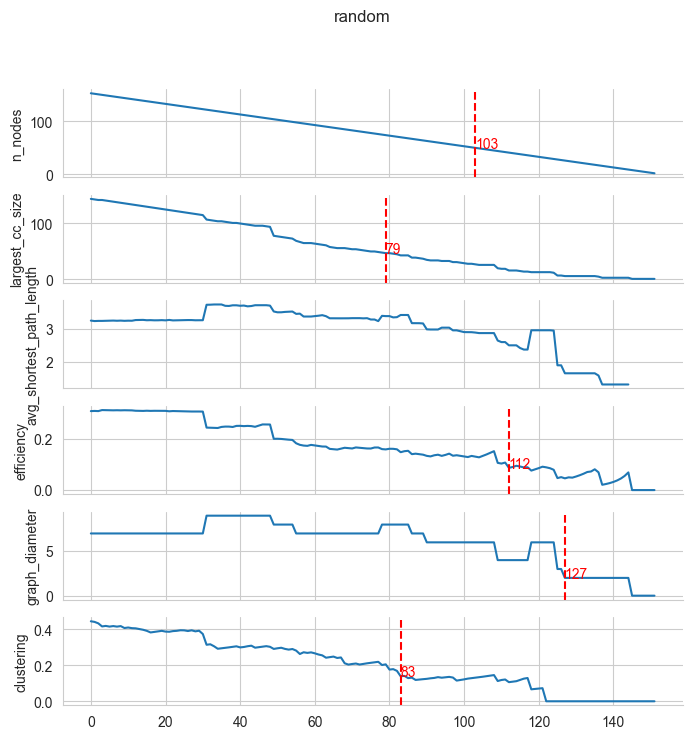

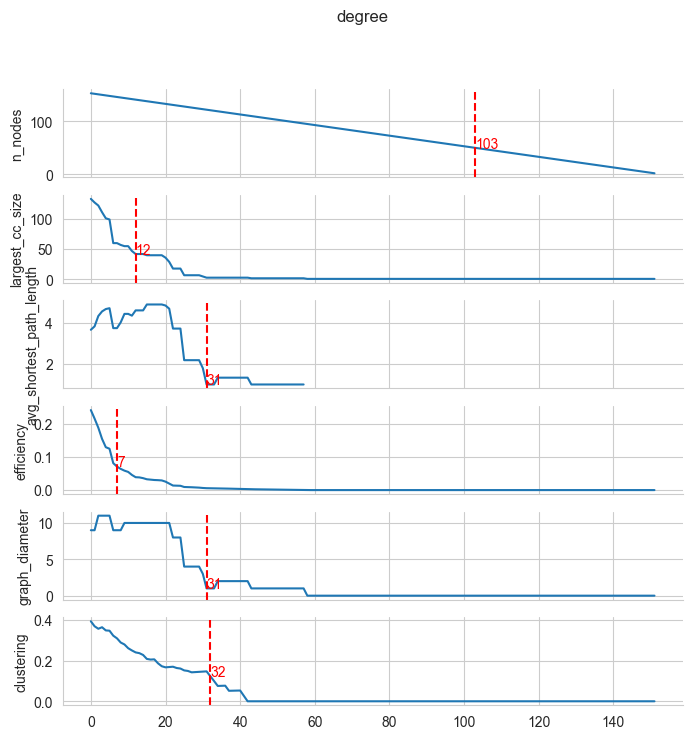

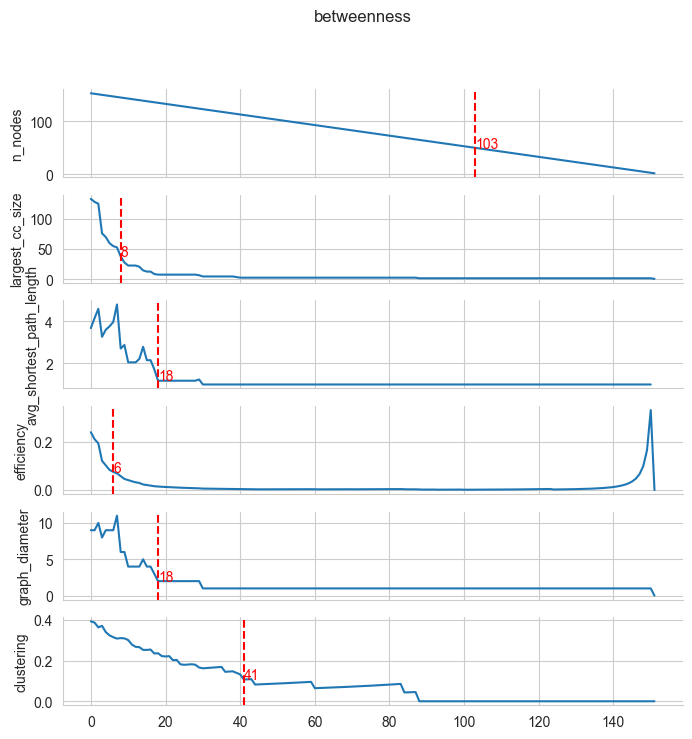

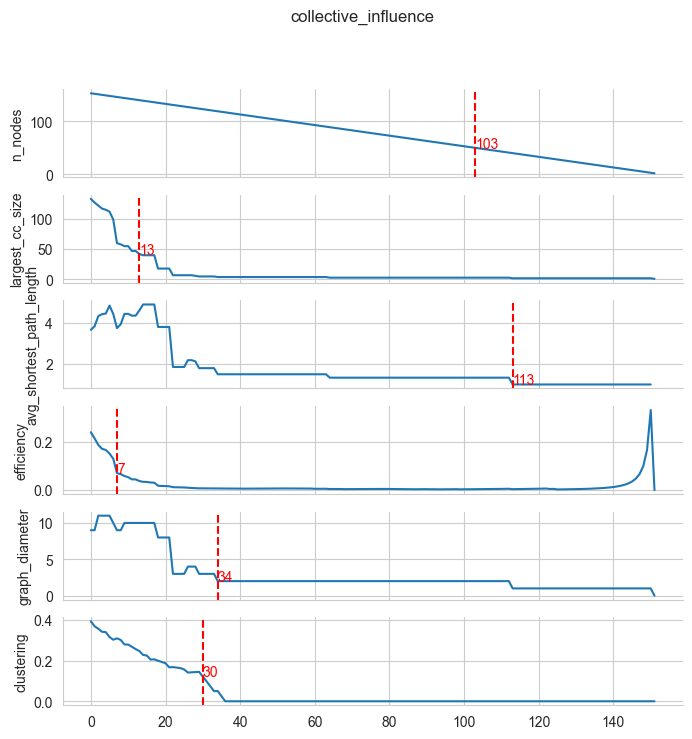

In [39]:
for method in ['random', 'degree', 'betweenness', 'collective_influence']:
    scan_disruption(G_combined, method)